# Long Short-Term Memory (LSTM)

Stock Market Predictions with LSTM in Python

Source: https://www.datacamp.com/tutorial/lstm-python-stock-market

In [ ]:
pip install tensorflow

In [ ]:
pip install pandas_datareader 

In [ ]:
pip install yfinance

In [ ]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import yfinance as yf
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [17]:
stock_ticker = yf.Ticker("AAL")
data_history = stock_ticker.history(period="20y")
print(data_history)

                                Open       High        Low      Close  \
Date                                                                    
2005-09-27 00:00:00-04:00  19.844706  20.174665  18.006361  18.194908   
2005-09-28 00:00:00-04:00  18.194910  19.354483  18.100637  19.326200   
2005-09-29 00:00:00-04:00  19.231928  19.401622  18.949107  19.052807   
2005-09-30 00:00:00-04:00  19.099939  19.844704  19.024520  19.806995   
2005-10-03 00:00:00-04:00  19.703295  20.504625  19.703295  20.268940   
...                              ...        ...        ...        ...   
2025-03-03 00:00:00-05:00  14.360000  14.560000  13.770000  13.870000   
2025-03-04 00:00:00-05:00  13.520000  13.650000  13.020000  13.350000   
2025-03-05 00:00:00-05:00  13.510000  14.230000  13.490000  14.090000   
2025-03-06 00:00:00-05:00  13.820000  13.930000  13.200000  13.250000   
2025-03-07 00:00:00-05:00  13.130000  13.180000  12.580000  13.030000   

                             Volume  Dividends  St

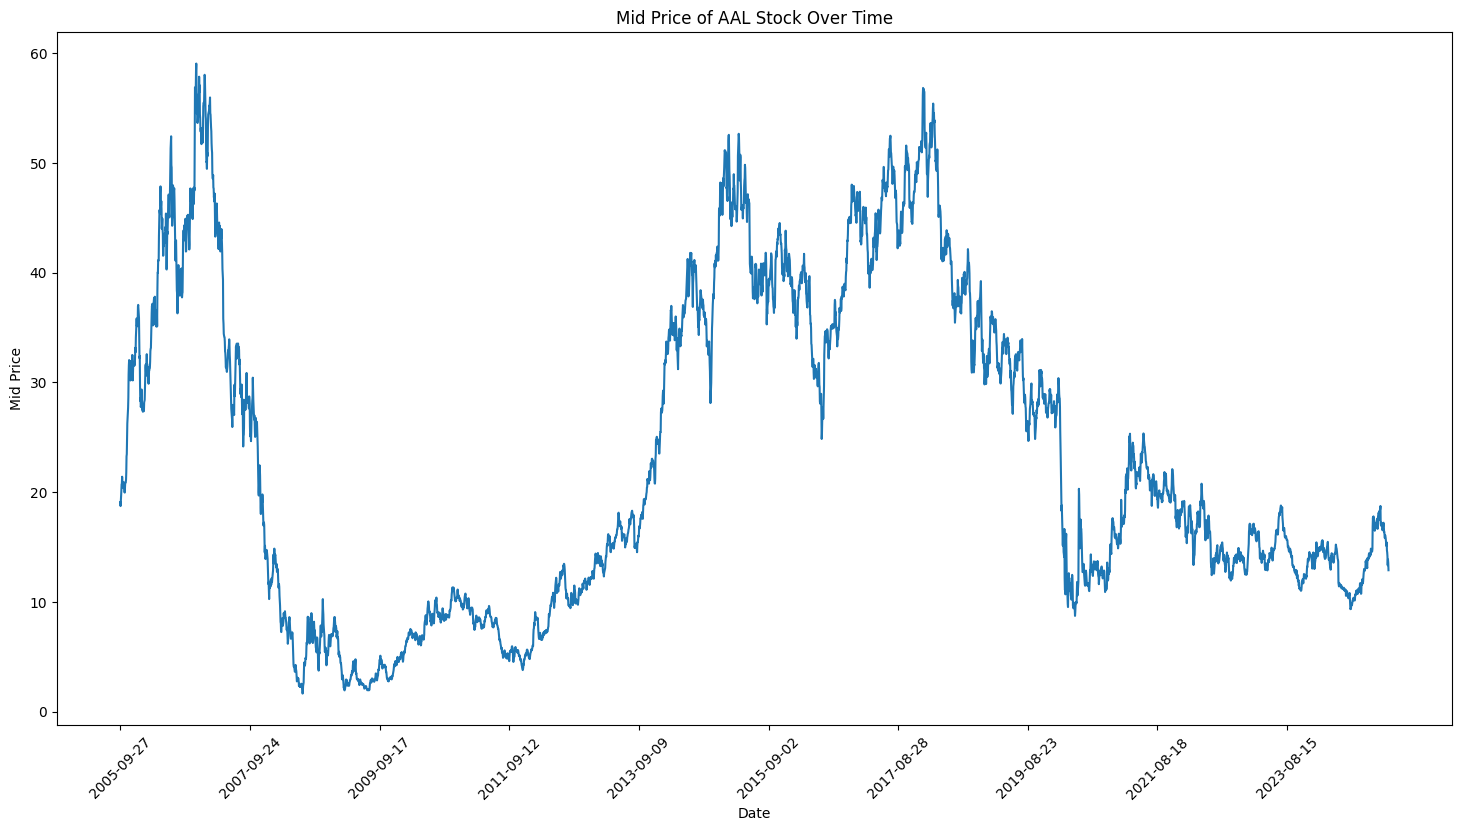

In [18]:
# Create a figure for plotting
plt.figure(figsize=(18, 9))

# Plot the mid price
plt.plot(range(data_history.shape[0]), (data_history['Low'] + data_history['High']) / 2.0)

# Set x-ticks using the index (dates)
plt.xticks(range(0, data_history.shape[0], 500), data_history.index[::500].date, rotation=45)

# Label the axes
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.title('Mid Price of AAL Stock Over Time')
plt.show()

# Splitting Data Into a Training Set and a Test Set

You will use the mid-price, which is calculated by taking the average of the highest and lowest recorded prices on a day.

In [20]:
# Extract high and low prices using .loc
high_prices = data_history.loc[:, 'High'].to_numpy()  # Use .to_numpy() instead of .as_matrix()
low_prices = data_history.loc[:, 'Low'].to_numpy()

# Calculate mid prices
mid_prices = (high_prices + low_prices) / 2.0

In [22]:
# The training data will be the first 11,000 data points of the time series, and the rest will be test data.
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

In [23]:
# Normalizing the Data
# MinMaxScalar scales all the data to be in the region of 0 and 1. You can also reshape the training and test data to be in the shape [data_size, num_features]
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [ ]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500

for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [ ]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize the test data
test_data = scaler.transform(test_data).reshape(-1)

In [ ]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(11000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)